Looking through the CD wow dataset to find useful customer patterns.

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dateutil import relativedelta as rd

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append("../")

from customercentric import dataprocessing

In [9]:
sns.set_style("ticks")

In [10]:
# read the data    
df = dataprocessing.read_cdwow("../data/cdwow/CDNOW_master.txt")

In [11]:
df.head()

,id,date,num_purchased,dollars,price_per_cd
0,1,1997-01-01,1,11.77,11.77
1,2,1997-01-12,1,12.00,12.00
2,2,1997-01-12,5,77.00,15.40
3,3,1997-01-02,2,20.76,10.38
4,3,1997-03-30,2,20.76,10.38


Looking at how the dataset evolves over time.
There's a strange bump in around March 1997,
and a few smaller events after that.

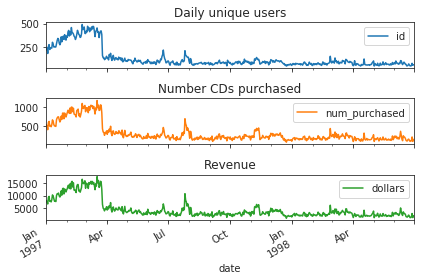

In [12]:
ax = (
    df
    .groupby("date")
    .agg({
        "id": "nunique",
        "num_purchased": "sum",
        "dollars": "sum"
    })
).plot(subplots=True)

ax[0].set_title("Daily unique users")
ax[1].set_title("Number CDs purchased")
ax[2].set_title("Revenue")

fig = plt.gcf()
fig.tight_layout()

How many purchases do we get per customer in the full time period?
This looks pretty much as I would expect,
most people only purchase once, but then there is a long tail.

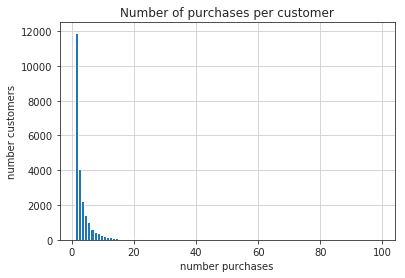

In [13]:
ax = (
    df
    .groupby("id")
    .agg({"date": len})
).hist(bins=np.arange(1, 100, 1))[0][0]

ax.set_title("Number of purchases per customer")
ax.set_xlabel("number purchases")
ax.set_ylabel("number customers");

Each time someone makes a transaction, 
they can buy multiple CDs.
How many do they buy?

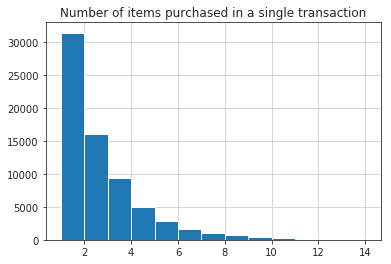

In [14]:
ax = df.num_purchased.hist(bins=np.arange(1, 15, 1))

ax.set_title("Number of items purchased in a single transaction");

We can also take a look at how much the average CD costs in the basket.
There was one that cost over $300.

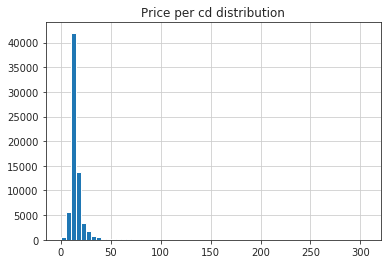

In [15]:
ax = df.price_per_cd.hist(bins=np.arange(0, df.price_per_cd.max(), 5))
ax.set_title("Price per cd distribution");

Papers like [Ticking away the moments: Timing Regularity
Helps to Better Predict Customer Activity](http://www.reutterer.com/papers/platzer&reutterer_pareto-ggg_2016.pdf) talk about different ways to measure the timing of the customer visits:

- Recency --- how long it was since the customer's most recent visit
- Frequency --- how many visits they made in a fixed time period
- Tenure --- how long they have been a customer for
- Clumpiness --- does the user make repeat visits regularly, or are they in short bursts of _binges_.

Some of these only make sense at a fixed point in time,
e.g. recency.
We can select a fixed point in time and calculate these measures for them.



In [16]:
reporting_date = df.date.max()

summary = dataprocessing.summarise_users(df, reporting_date)

100%|██████████| 23570/23570 [00:43<00:00, 548.13it/s]


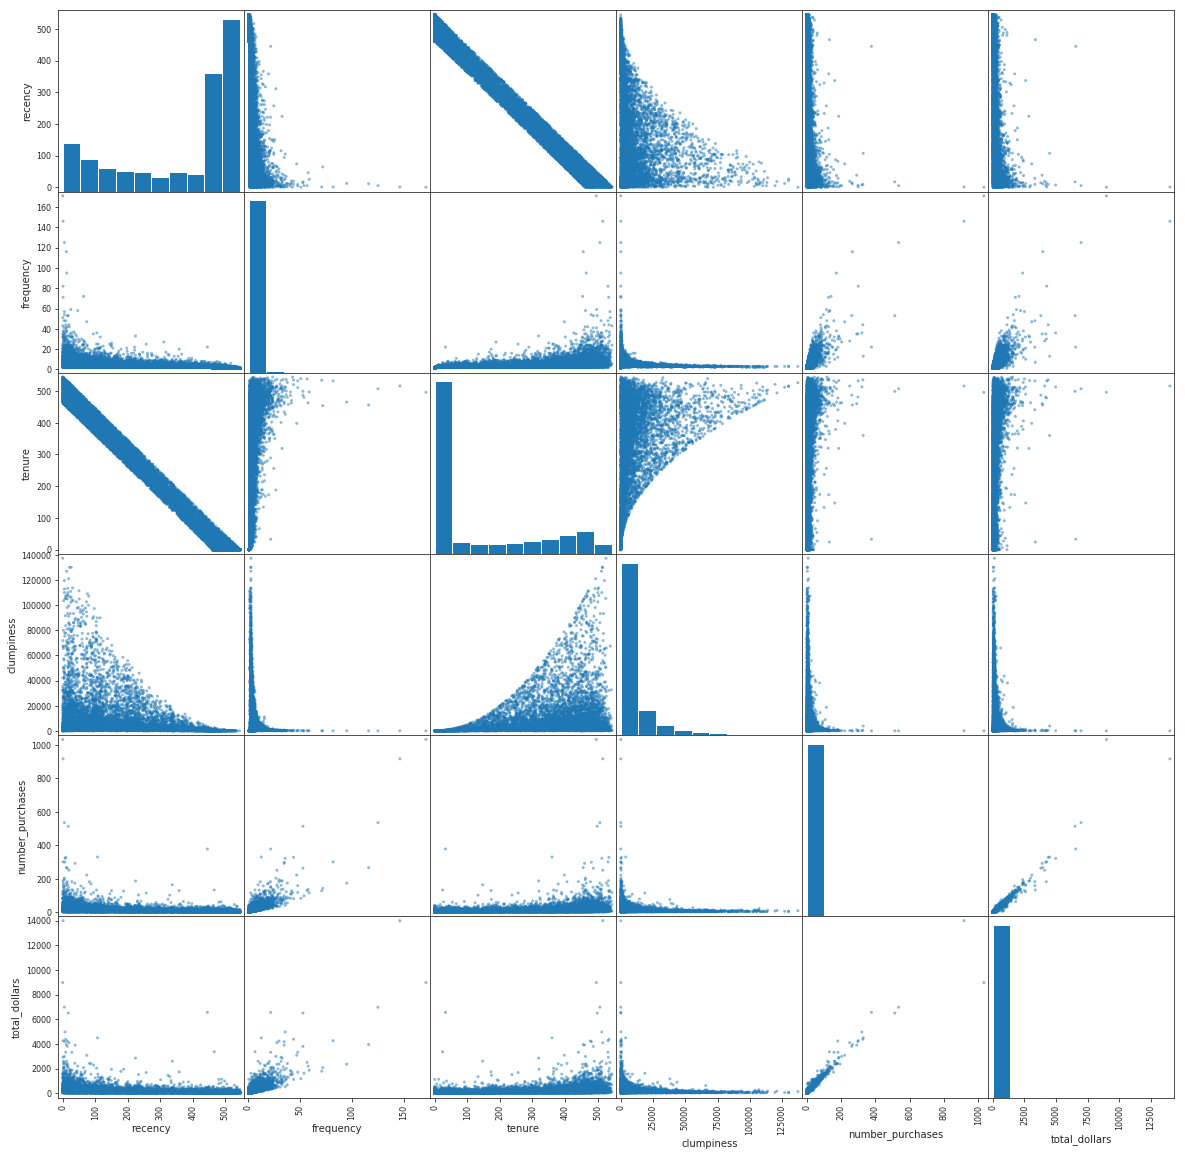

In [17]:
pd.plotting.scatter_matrix(summary, figsize=(20, 20));

In [ ]:
summary.head()

In [ ]:
def plot_user_subset(ax, subset, date_labels):
    subset = (
        subset
        .sort_values("id")
        .pipe(lambda x: x.assign(row= x.id.rank(method="dense")))
    )
    ax.scatter(subset.date, subset.row, alpha=0.4)
    ax.set_yticks(np.arange(1, len(subset.id.unique())+1, 1))
    ax.set_yticklabels(subset.id.unique())
    ax.set_xticks(date_labels)



def plot_sample_users(df, summary, variable, N):
    date_labels = pd.date_range(df.date.min(), df.date.max(), freq="M")    
    values = summary[variable]
    p10 = values.quantile(0.1)
    p90 = values.quantile(0.9)
    
    lo_ids = summary.loc[(summary[variable] <= p10)].sample(N).index
    hi_ids = summary.loc[(summary[variable] >= p90)].sample(N).index
    
    lo_users = df.loc[df.id.isin(lo_ids)]
    hi_users = df.loc[df.id.isin(hi_ids)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
    plot_user_subset(ax[0], lo_users, date_labels)
    plot_user_subset(ax[1], hi_users, date_labels)
    
    ax[0].set_title("Low {}".format(variable))
    ax[1].set_title("High {}".format(variable))    
    
    
plot_sample_users(df, summary, "clumpiness", 20)

In [ ]:
plot_sample_users(df, summary, "tenure", 20)

In [ ]:
plot_sample_users(df, summary, "total_dollars", 20)

In [ ]:
plot_sample_users(df, summary, "recency", 20)